# Сборный проект 5 - Поиск изображения по запросу.
<a id='head'></a>

## Описание проекта

Необходимо разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

Ссылка на проект в kaggle:
https://www.kaggle.com/code/denisur/project-5

## Загрузка библиотек

In [1]:
#!pip install --upgrade category-encoders -q
#!pip install scikit-learn --upgrade -q

In [2]:
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.image as img

import pandas as pd

from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import Ridge 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModel

import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize

from PIL import Image

import os

from tqdm import tqdm
from tqdm import notebook

import re

import warnings

import random

In [3]:
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tqdm.pandas()

pd.set_option('display.max_columns', None)

BATCH_SIZE = 10
RANDOM_STATE = 15
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
#torch.use_deterministic_algorithms(True)

TEST_SIZE = 0.3

train_img_directory = '/kaggle/input/ds-integrated-project-5/to_upload/train_images'
test_img_directory = '/kaggle/input/ds-integrated-project-5/to_upload/test_images'

DATA_PATH = '/kaggle/input/ds-integrated-project-5/to_upload/'

## Набор функций

In [4]:
m = WordNetLemmatizer()

token_model = 'sentence-transformers/all-MiniLM-L6-v2'
bert_model = AutoModel.from_pretrained(token_model).to(device)
tokenizer = AutoTokenizer.from_pretrained(token_model)

# Создаем отдельные скалеры для изображений и текста
img_scaler = MinMaxScaler()
text_scaler = MinMaxScaler()

In [5]:
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

In [6]:
def lemmatize_sent(text): 
    # Text input is string
    lemms =  [m.lemmatize(word, pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]
    return ' '.join(lemms)

In [7]:
def clear_text(text):
    clr_text = re.sub(r'[^a-zA-Z ]', ' ', text).lower()
    clr_text = re.sub(r'\b\w{1,2}\s+\w{1,2}\b', ' ', clr_text)
    clr_text = re.sub(r'\b\w\b', ' ', clr_text)
    clr_text = re.sub(r'\s+', ' ', clr_text).strip()
    words = clr_text.split()
    filtered_words = [word for word in words if word not in stop_words]
    clr_text = ' '.join(filtered_words)
    return clr_text

In [8]:
def numeric_analysis(df, column, annot):
    # выводим таблицу со статистикой и считаем усы боксплота
    stat = df[column].describe()
    print(stat)
    up_whisker = stat['75%'] + 1.5 * (stat['75%'] - stat['25%'])
    low_whisker = stat['25%'] - 1.5 * (stat['75%'] - stat['25%'])
    
    print(f'\nВерхний ус: {round(up_whisker, 2)} \nНижний ус: {round(low_whisker, 2)} \
    \nМедианное значение: {df[column].median()}')
    
    # строим ящик с усами и гистограмму признака
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(df[column], orient="h", ax=ax_box)
    sns.histplot(data=df, x=column, ax=ax_hist, bins=100, kde=True)
    plt.axvline(df[column].mean(), color='r', linestyle='-', label=f'Среднее значение: {round(df[column].mean(), 2)}')
    plt.axvline(df[column].median(), color='g', linestyle='--', label=f'Медианное значение: {round(df[column].median(), 2)}')
    ax_box.set(xlabel='')
    ax_hist.legend(loc='best')
    ax_box.set_title(f'График распределения {annot}', weight='bold')
    plt.show()

In [ ]:
def img_vector(path):
    resnet = models.resnet18(pretrained=True) #загружаем претренированную модель
    
    for param in resnet.parameters(): #фиксируем параметры 
        param.requires_grad_(False)
    
    modules = list(resnet.children())[:-1] #отключаем один верхний слой
    resnet = nn.Sequential(*modules,
                           nn.Flatten()
                          ).to(device)
    
    resnet.eval() #включаем режим оценки

    norm = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.RandomInvert(),
        transforms.ToTensor(),
        norm
        
    ]) #преобразовываем изображения
    img_data = []

    for filename in os.listdir(path):
        img_path = os.path.join(path, filename)
        img = Image.open(img_path).convert('RGB')
        image_tensor = preprocess(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = resnet(image_tensor)
    
        img_data.append({
            "image": filename,
            "img_vector": output.cpu().numpy().flatten()
        })

    return img_data, output

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #Первый элемент model_output содержит эмбдинги всех токенов
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [ ]:
def preprocess_text_with_pooling(text, distilbert_model, tokenizer):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = distilbert_model(**inputs)

    sentence_embeddings = mean_pooling(outputs, inputs['attention_mask'])

    return sentence_embeddings.cpu().numpy().squeeze()

In [ ]:
def data_merging(df1, df2, on, how, text_vector_col, image_vector_col, text_scaler, img_scaler):

    # Масштабируем текстовые векторы
    text_vectors = np.array(df1[text_vector_col].tolist())
    scaled_text = text_scaler.fit_transform(text_vectors)
    df1 = df1.copy()
    df1['scaled_text'] = list(scaled_text)

    # Масштабируем векторы изображений
    img_vectors = np.array(df2[image_vector_col].tolist())
    scaled_img = img_scaler.fit_transform(img_vectors)
    df2 = df2.copy()
    df2['scaled_img'] = list(scaled_img)

    # Объединяем DataFrame
    df_merged = pd.merge(
        df1, 
        df2, 
        on=on, 
        how=how
    )

    #Конкатенируем векторы для каждой строки
    df_merged['concat_vectors'] = df_merged.progress_apply(
        lambda row: np.concatenate([np.array(row['scaled_text']), np.array(row['scaled_img'])]),
                                   axis=1)
 
    df_merged = df_merged.drop(columns=['scaled_img', 'scaled_text'])
    
    return df_merged, text_scaler, img_scaler

## Загрузка данных

В файле train_dataset.csv собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. 

Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

In [13]:
ds_train = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'))

In [14]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [15]:
ds_train.head(10)

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
5,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
7,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
8,343218198_1ca90e0734.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
9,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


В файле CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. 

Номера колонок и соответствующий тип данных:
1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

In [16]:
ds_crowd_annot = pd.read_csv(os.path.join(DATA_PATH, 'CrowdAnnotations.tsv'), 
                             sep='\t', 
                             names=['image', 'query_id', 
                                    'mark_share', 
                                    'positive_count', 
                                    'negative_count'])

In [17]:
ds_crowd_annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   mark_share      47830 non-null  float64
 3   positive_count  47830 non-null  int64  
 4   negative_count  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [18]:
ds_crowd_annot.head()

,image,query_id,mark_share,positive_count,negative_count
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


В файле ExpertAnnotations.tsv содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
1. Имя файла изображения.
2. Идентификатор описания.
3. 3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где: 
- 1 — изображение и запрос совершенно не соответствуют друг другу, 
- 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 
- 3 — запрос и текст соответствуют с точностью до некоторых деталей, 
- 4 — запрос и текст соответствуют полностью.

In [19]:
ds_expert_annot = pd.read_csv(os.path.join(DATA_PATH, 'ExpertAnnotations.tsv'), sep='\t', 
                              names=['image', 'query_id', 'mark_1', 'mark_2', 'mark_3'])

In [20]:
ds_expert_annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   mark_1    5822 non-null   int64 
 3   mark_2    5822 non-null   int64 
 4   mark_3    5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [21]:
ds_expert_annot.head()

,image,query_id,mark_1,mark_2,mark_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. 

Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

In [22]:
ds_test_queries = pd.read_csv(os.path.join(DATA_PATH, 'test_queries.csv'), sep='|')

In [23]:
ds_test_queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


In [24]:
ds_test_queries.head()

,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [25]:
ds_test_queries.drop('Unnamed: 0', inplace=True, axis=1)

In [26]:
ds_test_queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


In [27]:
ds_test_images = pd.read_csv(os.path.join(DATA_PATH, 'test_images.csv'))

In [28]:
ds_test_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [29]:
ds_test_images.head()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


## Исследовательский анализ

Количество уникальных изображение в тренировочном датасете.

In [30]:
ds_train.columns

Index(['image', 'query_id', 'query_text'], dtype='object')

In [31]:
ds_train['image'].value_counts()

image
3107513635_fe8a21f148.jpg    10
488356951_b3b77ad832.jpg     10
3364151356_eecd07a23e.jpg    10
2083434441_a93bc6306b.jpg    10
3485425825_c2f3446e73.jpg    10
                             ..
3239021459_a6b71bb400.jpg     2
3227148358_f152303584.jpg     2
2914206497_5e36ac6324.jpg     2
3591462960_86045906bd.jpg     2
2533424347_cf2f84872b.jpg     2
Name: count, Length: 1000, dtype: int64

Всего 1000 изображений.

In [32]:
len(ds_train['query_text'].unique())

977

977 уникальных запроса.

Проверим на наличие пустых текстов.

In [33]:
empty_rows_count = ds_train['query_text'].isnull().sum() + (ds_train['query_text'] == '').sum()

print(f"Количество строк с пустым текстом: {empty_rows_count}")

Количество строк с пустым текстом: 0


Проверим кол-во уникальных изображений и запросов в тестовых выборках.

In [34]:
ds_test_queries.columns

Index(['query_id', 'query_text', 'image'], dtype='object')

In [35]:
ds_test_queries['image'].value_counts()

image
989851184_9ef368e520.jpg     5
1177994172_10d143cb8d.jpg    5
1232148178_4f45cc3284.jpg    5
123997871_6a9ca987b1.jpg     5
3730011701_5352e02286.jpg    5
                            ..
1745110280_0cbff5e273.jpg    5
186346360_541047336f.jpg     5
191003283_992257f835.jpg     5
1991806812_065f747689.jpg    5
2060031241_a3ae7a06bb.jpg    5
Name: count, Length: 100, dtype: int64

Количество соответствует датасету с количеством тестовых изображений.

In [36]:
len(ds_test_queries['query_text'].unique())

500

500 уникальных запроса.

In [37]:
ds_crowd_annot.columns

Index(['image', 'query_id', 'mark_share', 'positive_count', 'negative_count'], dtype='object')

count    47830.000000
mean         0.068786
std          0.207532
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: mark_share, dtype: float64

Верхний ус: 0.0 
Нижний ус: 0.0     
Медианное значение: 0.0


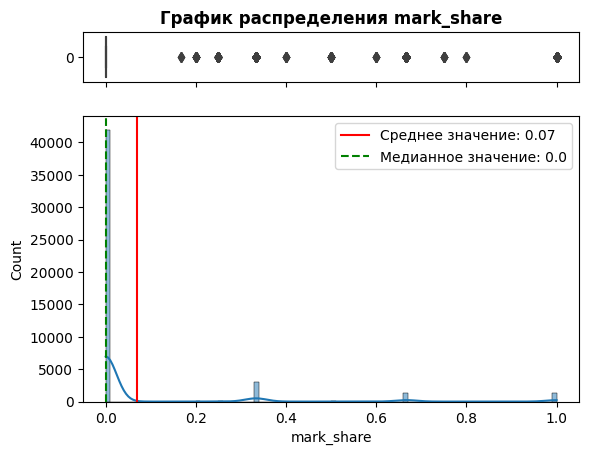

In [38]:
numeric_analysis(ds_crowd_annot, 'mark_share', 'mark_share')

In [39]:
ds_crowd_annot['mark_share'].value_counts(normalize=True)

mark_share
0.000000    0.877483
0.333333    0.062722
0.666667    0.028434
1.000000    0.027660
0.250000    0.002007
0.500000    0.000564
0.200000    0.000460
0.750000    0.000188
0.600000    0.000167
0.400000    0.000167
0.800000    0.000084
0.166667    0.000063
Name: proportion, dtype: float64

Более 80% запросов не соответствует изображению по мнению краудсорсинга.

Проверим распределение оценок экспертов.

In [40]:
ds_expert_annot.columns

Index(['image', 'query_id', 'mark_1', 'mark_2', 'mark_3'], dtype='object')

Распределение оценок первого эксперта.

In [41]:
ds_expert_annot['mark_1'].value_counts(normalize=True)

mark_1
1    0.707661
2    0.190484
3    0.059430
4    0.042425
Name: proportion, dtype: float64

Распределение оценок второго эксперта.

In [42]:
ds_expert_annot['mark_2'].value_counts(normalize=True)

mark_2
1    0.571453
2    0.286156
3    0.088973
4    0.053418
Name: proportion, dtype: float64

Распределение оценок третьего эксперта.

In [43]:
ds_expert_annot['mark_3'].value_counts(normalize=True)

mark_3
1    0.403641
2    0.381656
3    0.143765
4    0.070938
Name: proportion, dtype: float64

Судя по всему первый эксперт относился более строго к оценке соответствия запроса изображению.

## Объединение данных

Отберу запрещенные слова, но перед этим очищу запросы.

In [44]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [45]:
ds_train['query_text'] = ds_train['query_text'].progress_apply(clear_text)

100%|██████████| 5822/5822 [00:00<00:00, 70225.72it/s]


In [46]:
all_words = []

for t in ds_train['query_text']:
    words = word_tokenize(t)
    all_words.extend(words)

In [47]:
unique_words = sorted(set(all_words))

In [48]:
ds_train.columns

Index(['image', 'query_id', 'query_text'], dtype='object')

In [49]:
prohib_words = ['kid', 'kids', 'child', 'children', 'boy', 'boys', 'girl', 'girls', 'baby', 'babies', 'young']

In [50]:
ds_prohib_queries = ds_train[ds_train.query_text.str.contains('|'.join(prohib_words))]

In [51]:
ds_prohib_queries.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...


In [52]:
list_prohib_img = ds_prohib_queries['query_id'].tolist()

In [53]:
modified_list_prohib_img = [item[:-2] for item in list_prohib_img]

In [54]:
ds_train_clean = ds_train[~ds_train.image.str.contains('|'.join(modified_list_prohib_img))].reset_index(drop=True)

In [55]:
ds_train_clean[ds_train_clean['image']==  '979383193_0a542a059d.jpg']

,image,query_id,query_text


In [56]:
ds_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4028 entries, 0 to 4027
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       4028 non-null   object
 1   query_id    4028 non-null   object
 2   query_text  4028 non-null   object
dtypes: object(3)
memory usage: 94.5+ KB


Теперь посчитаю оценку соответствия картинки описанию у экспертов.

In [57]:
ds_expert_annot.columns

Index(['image', 'query_id', 'mark_1', 'mark_2', 'mark_3'], dtype='object')

In [58]:
ds_expert_annot['final_score'] = ((ds_expert_annot['mark_1'] - 1)/3 + (ds_expert_annot['mark_2'] - 1)/3 + (ds_expert_annot['mark_3'] - 1)/3)/3

In [59]:
ds_expert_annot.head()

,image,query_id,mark_1,mark_2,mark_3,final_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0.111111
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,0.111111
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,0.222222
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,0.111111


Посмотрим на распределение оценок.

count    5822.000000
mean        0.215886
std         0.268735
min         0.000000
25%         0.000000
50%         0.111111
75%         0.333333
max         1.000000
Name: final_score, dtype: float64

Верхний ус: 0.83 
Нижний ус: -0.5     
Медианное значение: 0.1111111111111111


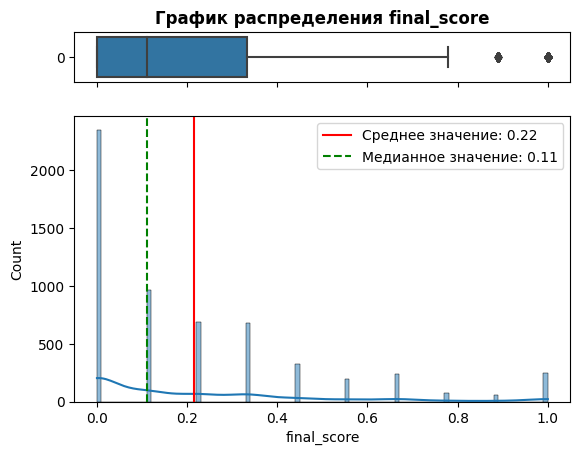

In [60]:
numeric_analysis(ds_expert_annot, 'final_score', 'final_score')

Теперь объединим датасеты чтобы получить окончательную оценку.

In [61]:
ds_train_merged = pd.merge(ds_train_clean ,ds_expert_annot, on=['image', 'query_id'], how='left')

In [62]:
ds_train_merged.head()

,image,query_id,query_text,mark_1,mark_2,mark_3,final_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,1,1,1,0.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,1,1,1,0.0
2,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,1,1,1,0.0
3,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,1,1,1,0.0
4,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,1,1,1,0.0


In [63]:
ds_train_merged.drop(['mark_1', 'mark_2', 'mark_3', ], axis=1, inplace=True)

### Собранный датасет

In [64]:
ds_train_merged.head()

,image,query_id,query_text,final_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,0.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,0.0
2,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,0.0
3,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,0.0
4,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,0.0


In [65]:
ds_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4028 entries, 0 to 4027
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        4028 non-null   object 
 1   query_id     4028 non-null   object 
 2   query_text   4028 non-null   object 
 3   final_score  4028 non-null   float64
dtypes: float64(1), object(3)
memory usage: 126.0+ KB


## Векторизация изображений

In [66]:
train_img_data, train_output = img_vector(train_img_directory)

In [67]:
train_output.shape

torch.Size([1, 512])

In [68]:
img_vectors = pd.DataFrame(train_img_data)

In [69]:
img_vectors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       1000 non-null   object
 1   img_vector  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


## Векторизация текста

In [70]:
ds_train_merged.columns

Index(['image', 'query_id', 'query_text', 'final_score'], dtype='object')

In [71]:
ds_train_merged['text_vector'] = ds_train_merged['query_text'].progress_apply(lambda x: preprocess_text_with_pooling(x, bert_model, tokenizer))

100%|██████████| 4028/4028 [00:16<00:00, 241.46it/s]


In [72]:
ds_train_merged.head()

,image,query_id,query_text,final_score,text_vector
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,0.0,"[-0.21842393, 0.035592575, 0.21395111, -0.0632..."
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,0.0,"[-0.21842393, 0.035592575, 0.21395111, -0.0632..."
2,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,0.0,"[-0.21842393, 0.035592575, 0.21395111, -0.0632..."
3,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,0.0,"[-0.21842393, 0.035592575, 0.21395111, -0.0632..."
4,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,0.0,"[-0.21842393, 0.035592575, 0.21395111, -0.0632..."


## Объединение векторов

In [73]:
df_train_to_work, text_scaler, img_scaler = data_merging(ds_train_merged, img_vectors, 'image', 'left', 'text_vector', 'img_vector', text_scaler, img_scaler)

100%|██████████| 4028/4028 [00:00<00:00, 64485.88it/s]


In [74]:
df_train_to_work.head()

,image,query_id,query_text,final_score,text_vector,img_vector,concat_vectors
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,0.0,"[-0.21842393, 0.035592575, 0.21395111, -0.0632...","[0.6939423, 3.0318372, 2.9169343, 0.95189714, ...","[0.3856389, 0.37206435, 0.47515675, 0.48896807..."
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,0.0,"[-0.21842393, 0.035592575, 0.21395111, -0.0632...","[0.4288915, 1.1513165, 1.1856481, 1.2804345, 0...","[0.3856389, 0.37206435, 0.47515675, 0.48896807..."
2,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,0.0,"[-0.21842393, 0.035592575, 0.21395111, -0.0632...","[2.1992736, 1.6522435, 2.4724598, 0.9682944, 0...","[0.3856389, 0.37206435, 0.47515675, 0.48896807..."
3,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,0.0,"[-0.21842393, 0.035592575, 0.21395111, -0.0632...","[0.47678718, 0.5161172, 1.5059168, 0.8794652, ...","[0.3856389, 0.37206435, 0.47515675, 0.48896807..."
4,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,young child wearing blue goggles sitting float...,0.0,"[-0.21842393, 0.035592575, 0.21395111, -0.0632...","[1.8598635, 2.0731764, 1.1162574, 1.7515749, 0...","[0.3856389, 0.37206435, 0.47515675, 0.48896807..."


In [75]:
df_train_to_work.drop(columns=['text_vector', 'img_vector'], inplace=True)

In [76]:
df_train_to_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4028 entries, 0 to 4027
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           4028 non-null   object 
 1   query_id        4028 non-null   object 
 2   query_text      4028 non-null   object 
 3   final_score     4028 non-null   float64
 4   concat_vectors  4028 non-null   object 
dtypes: float64(1), object(4)
memory usage: 157.5+ KB


## Подготовка данных для обучения

In [77]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOM_STATE)
train_indices, val_indices = next(gss.split(X=df_train_to_work.drop(columns=['final_score']), y=df_train_to_work['final_score'], groups=df_train_to_work['image']))
train_df, val_df = df_train_to_work.loc[train_indices], df_train_to_work.loc[val_indices]

In [78]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2801 entries, 0 to 4027
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           2801 non-null   object 
 1   query_id        2801 non-null   object 
 2   query_text      2801 non-null   object 
 3   final_score     2801 non-null   float64
 4   concat_vectors  2801 non-null   object 
dtypes: float64(1), object(4)
memory usage: 131.3+ KB


In [79]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1227 entries, 6 to 4022
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           1227 non-null   object 
 1   query_id        1227 non-null   object 
 2   query_text      1227 non-null   object 
 3   final_score     1227 non-null   float64
 4   concat_vectors  1227 non-null   object 
dtypes: float64(1), object(4)
memory usage: 57.5+ KB


### Линейная регрессия

Так как мы решаем задачу регрессии, то основную метрику для оптимизации я выбрал MAE. Целевой признак имеет распределение от 0 до 1, поэтому можно проще читать как сильно ошибается модель.

In [80]:
X_train = np.vstack(train_df['concat_vectors'].values)
y_train = train_df['final_score'].values

In [81]:
X_val = np.vstack(val_df['concat_vectors'].values)
y_val = val_df['final_score'].values

In [82]:
X_val[:10]

array([[0.3856389 , 0.37206435, 0.47515675, ..., 0.04097361, 0.05418816,
        0.0328941 ],
       [0.3856389 , 0.37206435, 0.47515675, ..., 0.09529693, 0.19079795,
        0.06606627],
       [0.41806522, 0.37586173, 0.54153323, ..., 0.2510319 , 0.0932318 ,
        0.15389381],
       ...,
       [0.46108827, 0.6015224 , 0.16005357, ..., 0.22819409, 0.04191458,
        0.01194115],
       [0.42862573, 0.51868373, 0.23943111, ..., 0.14542054, 0.06671967,
        0.05817013],
       [0.42862573, 0.51868373, 0.23943111, ..., 0.05011937, 0.0824446 ,
        0.12993774]], dtype=float32)

In [83]:
lr_model = Ridge(random_state=RANDOM_STATE)

In [84]:
lr_model.fit(X_train, y_train)

Ridge(random_state=15)

In [85]:
preds = lr_model.predict(X_val)

In [86]:
lr_mae = mae(y_val, preds)

In [87]:
print(f'Метрика MAE линейной регрессии: {round(lr_mae, 2)}')

Метрика MAE линейной регрессии: 0.25


In [88]:
preds[:10]

array([ 0.23087937,  0.09849474,  0.12258305,  0.26732746,  0.06644887,
        0.2323652 ,  0.16519566,  0.22294635,  0.2061325 , -0.19087912],
      dtype=float32)

In [89]:
df_true_preds = pd.DataFrame({'true': y_val, 
              'predictions': preds}).head()

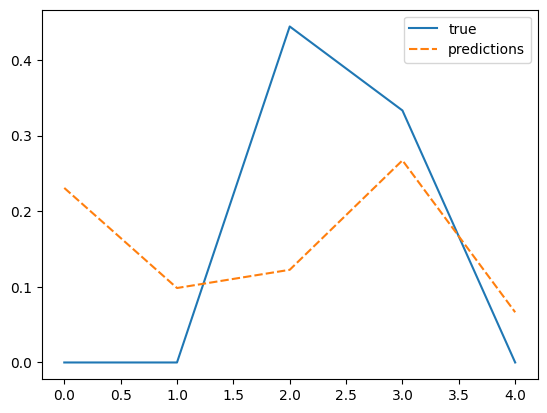

In [90]:
sns.lineplot(df_true_preds)
plt.show()

### Полносвязная нейронная сеть

In [91]:
X_train = torch.FloatTensor(X_train).to(device)
X_val = torch.FloatTensor(X_val).to(device)
y_train = torch.FloatTensor(y_train).to(device)
y_val = torch.FloatTensor(y_val).to(device)

In [92]:
X_train.shape

torch.Size([2801, 896])

In [93]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, 
                 n_hidden_neurons_1, 
                 n_hidden_neurons_2,
                 n_out_neurons, 
                 dropout_rate_1=0.0, 
                 dropout_rate_2=0.0,
                 weight_init=nn.init.xavier_uniform_
                ):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.dp1 = nn.Dropout(dropout_rate_1)
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.dp2 = nn.Dropout(dropout_rate_2)

        self.fc5 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
        weight_init(self.fc1.weight)
        weight_init(self.fc2.weight)


    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.dp2(x)
        
        x = self.fc5(x)
        
        return x

In [94]:
param_grid = {
    'weight_init': [nn.init.xavier_normal_, nn.init.xavier_uniform_],
    'module__dropout_rate_1': [0.3, 0.5],
    'module__dropout_rate_2': [0.3, 0.5],
    'max_epochs': [6000]
}

In [95]:
best_val_mae = float('inf')
best_model_state = None  # Для сохранения весов лучшей модели

mae_train_history = []
mae_val_history = [] 

best_params = {}

In [96]:
for num_epochs in param_grid['max_epochs']:
        for weight_init in param_grid['weight_init']:
            for dropout_rate_1 in param_grid['module__dropout_rate_1']:
                for dropout_rate_2 in param_grid['module__dropout_rate_2']:
                            net_model = Net(n_in_neurons=X_train.shape[1],
                                        n_hidden_neurons_1=512, 
                                        n_hidden_neurons_2=8,
                                        n_out_neurons=1, 
                                        dropout_rate_1=dropout_rate_1,
                                        dropout_rate_2=dropout_rate_2,
                                        weight_init=weight_init
                                       ).to(device)
        
                            optimizer = torch.optim.Adam(net_model.parameters(), lr=1e-5, eps=1e-08)
                            loss = nn.L1Loss()
        
                            for epoch in range(num_epochs):
                                order = np.random.permutation(len(X_train))
    
                                net_model.train()
                                    
                                optimizer.zero_grad()
        
                                X_shuffle = X_train[order].to(device)
                                y_shuffle = y_train[order].to(device)
        
                                preds = net_model.forward(X_shuffle).flatten()
                                loss_value = loss(preds, y_shuffle)
        
                                loss_value.backward()
                                    
                                optimizer.step()
        
                                if epoch % 10 == 0 or epoch == num_epochs - 1:
                                    net_model.eval()
                                    with torch.no_grad():
                                        val_preds = net_model.forward(X_val).flatten()
                                        mae_loss = nn.L1Loss()
                                        mae_train = mae_loss(preds, y_shuffle)
                                        mae_val = mae_loss(val_preds, y_val)

                                        mae_train_history.append(mae_train)
                                        mae_val_history.append(mae_val)
                                        
        
                                        print(f'Epoch num: {epoch}\tTrain MAE: {mae_train.item():0.06f}\t' 
                                              f'Val MAE: {mae_val.item():0.06f}')
                                        
                                        if mae_val < best_val_mae:
                                            best_val_mae = mae_val.item()
                                            best_model_state = net_model.state_dict().copy()
                                            best_params = {
                                                'weight_init': weight_init,
                                                'dropout_rate_1': dropout_rate_1,
                                                'dropout_rate_2': dropout_rate_2
                                            }
                                        elif (epoch > 500) and (mae_val > best_val_mae * 1.05):
                                            break

Epoch num: 0	Train MAE: 0.557070	Val MAE: 0.307823
Epoch num: 10	Train MAE: 0.558987	Val MAE: 0.283218
Epoch num: 20	Train MAE: 0.555195	Val MAE: 0.305410
Epoch num: 30	Train MAE: 0.551123	Val MAE: 0.344241
Epoch num: 40	Train MAE: 0.547222	Val MAE: 0.385883
Epoch num: 50	Train MAE: 0.543942	Val MAE: 0.413061
Epoch num: 60	Train MAE: 0.534893	Val MAE: 0.425114
Epoch num: 70	Train MAE: 0.535280	Val MAE: 0.428270
Epoch num: 80	Train MAE: 0.541717	Val MAE: 0.430567
Epoch num: 90	Train MAE: 0.531146	Val MAE: 0.429601
Epoch num: 100	Train MAE: 0.530626	Val MAE: 0.428920
Epoch num: 110	Train MAE: 0.529134	Val MAE: 0.427292
Epoch num: 120	Train MAE: 0.519733	Val MAE: 0.424985
Epoch num: 130	Train MAE: 0.528138	Val MAE: 0.423706
Epoch num: 140	Train MAE: 0.524687	Val MAE: 0.423758
Epoch num: 150	Train MAE: 0.524750	Val MAE: 0.424007
Epoch num: 160	Train MAE: 0.519437	Val MAE: 0.425000
Epoch num: 170	Train MAE: 0.523189	Val MAE: 0.424474
Epoch num: 180	Train MAE: 0.516447	Val MAE: 0.423443
Epoc

In [97]:
best_params

{'weight_init': <function torch.nn.init.xavier_normal_(tensor: torch.Tensor, gain: float = 1.0, generator: Optional[torch._C.Generator] = None) -> torch.Tensor>,
 'dropout_rate_1': 0.3,
 'dropout_rate_2': 0.5}

In [98]:
best_model = Net(
    n_in_neurons=X_train.shape[1],
    n_hidden_neurons_1=512,
    n_hidden_neurons_2=8,
    n_out_neurons=1,
    dropout_rate_1=best_params['dropout_rate_1'],
    dropout_rate_2=best_params['dropout_rate_2'],
    weight_init=best_params['weight_init']
).to(device)

In [99]:
best_model.load_state_dict(best_model_state)

<All keys matched successfully>

## Тестирование модели

In [100]:
#Векторизуем изображения
test_img_vector, _ = img_vector(test_img_directory)

In [ ]:
def test_function(query, test_img_vector, test_img_directory, tokenizer, bert_model, prohibited_words, text_scaler, img_scaler):

    #Проверяем запрос на соответствие закона
    if any(word in query.lower() for word in prohibited_words):
        print("Запрос содержит запрещенные формулировки")
        return
    

    test_img_data = pd.DataFrame(test_img_vector)

    test_img_data['query'] = query
    
    #Очистим запрос
    clear_query = clear_text(query)
    
    #Токенизируем запрос
    tokenized = tokenizer.encode(clear_query, 
                                 add_special_tokens=True, 
                                 padding='max_length', 
                                 truncation=True)
    tokenized_array = np.array(tokenized)
    attention_mask = np.where(tokenized_array != 0, 1, 0)

        
    batch = torch.LongTensor(tokenized_array).unsqueeze(0).to(device)
    
    attention_mask_batch = torch.LongTensor(attention_mask).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = bert_model(batch, attention_mask=attention_mask_batch, output_hidden_states=True)
    
    last_hidden = output.last_hidden_state
    cls_embeddings = last_hidden[:, 0, :].cpu().numpy()

    text_vectors = np.tile(cls_embeddings, (len(test_img_data), 1))
    test_img_data['text_vector'] = list(text_vectors)

    # Масштабируем текстовые векторы
    text_vectors = np.array(test_img_data['text_vector'].tolist())
    scaled_text = text_scaler.transform(text_vectors)
    test_img_data['scaled_text'] = list(scaled_text)

    # Масштабируем векторы изображений
    img_vectors = np.array(test_img_data['img_vector'].tolist())
    scaled_img = img_scaler.transform(img_vectors)
    test_img_data['scaled_img'] = list(scaled_img)

    #Конкатенируем векторы для каждой строки
    test_img_data['concat_vectors'] = test_img_data.progress_apply(
        lambda row: np.concatenate([np.array(row['scaled_text']), np.array(row['scaled_img'])]),
                                   axis=1)

    test_img_data = test_img_data.drop(columns=['scaled_img', 'scaled_text'])

    X_test = torch.FloatTensor(np.vstack(test_img_data['concat_vectors'].values)).to(device)

    best_model.eval()
    with torch.no_grad():
        test_preds = best_model(X_test).squeeze().cpu().numpy()

    test_img_data['pred_score'] = test_preds

    test_img_data.sort_values('pred_score', ascending=False, inplace=True)

    image = img.imread(f"{test_img_directory}/{test_img_data['image'].iloc[0]}")
        
    plt.imshow(np.array(image))

    print(f"Prediction score: {test_img_data['pred_score'].iloc[0]}")
    print(f"File name: {test_img_data['image'].iloc[0]}")
    print(f"Query: {test_img_data['query'].iloc[0]}")

    test_img_data.head()
    

In [102]:
random_querries = ds_test_queries.sample(n=10)

In [103]:
pd.set_option('display.max_colwidth', None)

In [104]:
random_querries

,query_id,query_text,image
93,2399219552_bbba0a9a59.jpg#3,little boy playing basketball in the grass,2399219552_bbba0a9a59.jpg
440,440190907_bf8b7ba8ef.jpg#0,A group of people walk through a shopping mall .,440190907_bf8b7ba8ef.jpg
23,1429546659_44cb09cbe2.jpg#3,"Two dogs are standing next to each other , and the white dog has a stick in its mouth .",1429546659_44cb09cbe2.jpg
180,2887171449_f54a2b9f39.jpg#0,A woman sitting at a sewing machine looks up .,2887171449_f54a2b9f39.jpg
358,3466891862_9afde75568.jpg#3,The small dog returns with his stick proudly .,3466891862_9afde75568.jpg
179,2885891981_6b02620ae9.jpg#4,The man is on a black and white bike .,2885891981_6b02620ae9.jpg
248,3154152744_4e93ec8a62.jpg#3,Two dogs fighting over a toy in the snow .,3154152744_4e93ec8a62.jpg
414,3690425778_3b390b3ea5.jpg#4,"The person wearing shorts and a shirt is jumping off a dock , into the water .",3690425778_3b390b3ea5.jpg
470,862156271_3eacea90a8.jpg#0,Girls with orange hair standing on the street with some kind of bottle in their hand .,862156271_3eacea90a8.jpg
411,3690425778_3b390b3ea5.jpg#1,A person jumping off a dock into water .,3690425778_3b390b3ea5.jpg


100%|██████████| 100/100 [00:00<00:00, 37042.34it/s]


Prediction score: 0.32096046209335327
File name: 3356748019_2251399314.jpg
Query: A group of people walk through a shopping mall .


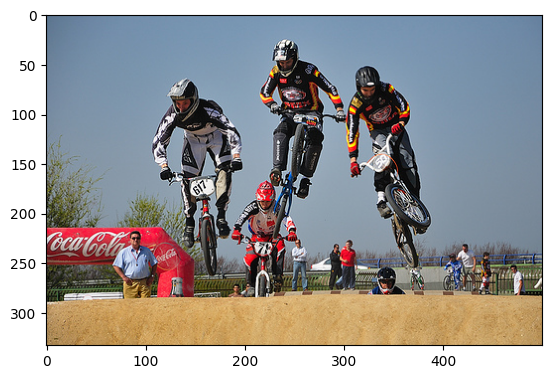

In [118]:
test_function('A group of people walk through a shopping mall .',
              test_img_vector,
              test_img_directory,
              tokenizer,
              bert_model,
              prohib_words, 
              text_scaler, 
              img_scaler
             )

100%|██████████| 100/100 [00:00<00:00, 37362.41it/s]

Prediction score: 0.39138925075531006
File name: 3154152744_4e93ec8a62.jpg
Query: The small dog returns with his stick proudly .


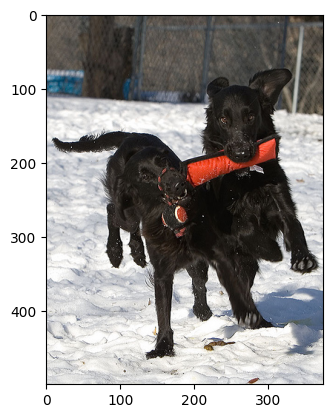

In [106]:
test_function('The small dog returns with his stick proudly .',
              test_img_vector,
              test_img_directory,
              tokenizer,
              bert_model,
              prohib_words, 
              text_scaler, 
              img_scaler
             )

100%|██████████| 100/100 [00:00<00:00, 34233.63it/s]


Prediction score: 0.31965404748916626
File name: 3722572342_6904d11d52.jpg
Query: The dog jumps up to catch the red ball .	


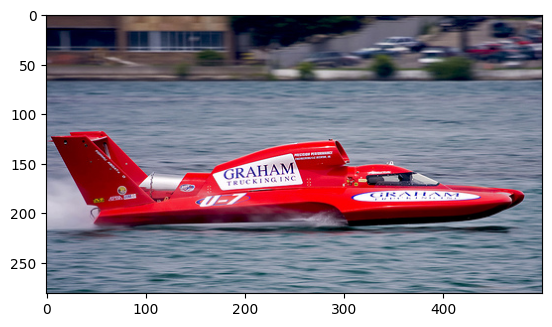

In [107]:
test_function('The dog jumps up to catch the red ball .	',
              test_img_vector,
              test_img_directory,
              tokenizer,
              bert_model,
              prohib_words, 
              text_scaler, 
              img_scaler
             )

100%|██████████| 100/100 [00:00<00:00, 37121.02it/s]


Prediction score: 0.5692718029022217
File name: 3730011701_5352e02286.jpg
Query: Camera man in populated building taping an event .


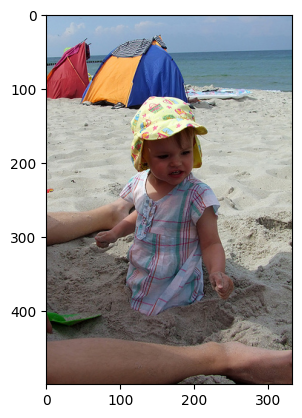

In [108]:
test_function("Camera man in populated building taping an event .",
              test_img_vector,
              test_img_directory,
              tokenizer,
              bert_model,
              prohib_words, 
              text_scaler, 
              img_scaler
             )

100%|██████████| 100/100 [00:00<00:00, 39199.10it/s]

Prediction score: 0.35563117265701294
File name: 3730011701_5352e02286.jpg
Query: Two people , one in blue and one in red , stand in front of a building .


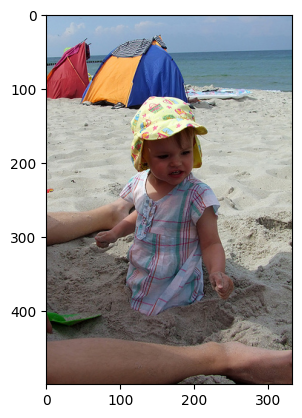

In [109]:
test_function("Two people , one in blue and one in red , stand in front of a building .",
              test_img_vector,
              test_img_directory,
              tokenizer,
              bert_model,
              prohib_words, 
              text_scaler, 
              img_scaler
             )

100%|██████████| 100/100 [00:00<00:00, 38554.13it/s]


Prediction score: 0.3474348187446594
File name: 3722572342_6904d11d52.jpg
Query: Red boat marked GRAHAM races across water .


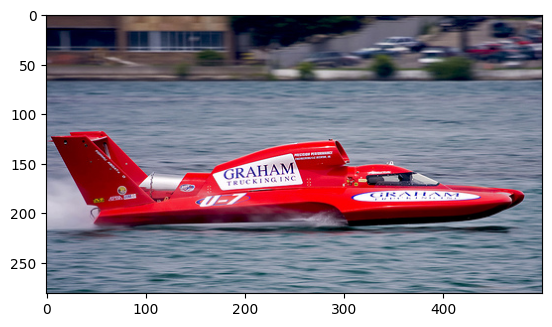

In [110]:
test_function("Red boat marked GRAHAM races across water .",
              test_img_vector,
              test_img_directory,
              tokenizer,
              bert_model,
              prohib_words, 
              text_scaler, 
              img_scaler
             )

100%|██████████| 100/100 [00:00<00:00, 43970.06it/s]


Prediction score: 0.46602606773376465
File name: 2517284816_9b8fd3c6b6.jpg
Query: Three people are doing ballet exercises in extravagant costumes .


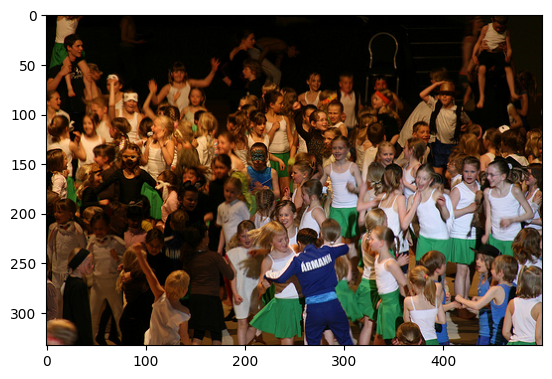

In [111]:
test_function("Three people are doing ballet exercises in extravagant costumes .",
              test_img_vector,
              test_img_directory,
              tokenizer,
              bert_model,
              prohib_words, 
              text_scaler, 
              img_scaler
             )

100%|██████████| 100/100 [00:00<00:00, 37593.47it/s]


Prediction score: 0.4592796266078949
File name: 3154152744_4e93ec8a62.jpg
Query: The brown dog is wearing a black collar .


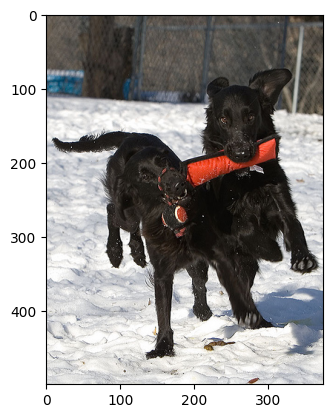

In [112]:
test_function("The brown dog is wearing a black collar .",
              test_img_vector,
              test_img_directory,
              tokenizer,
              bert_model,
              prohib_words, 
              text_scaler, 
              img_scaler
             )

100%|██████████| 100/100 [00:00<00:00, 39067.66it/s]

Prediction score: 0.5077935457229614
File name: 3730011701_5352e02286.jpg
Query: Three men on mountain bikes go over a sand hill .	


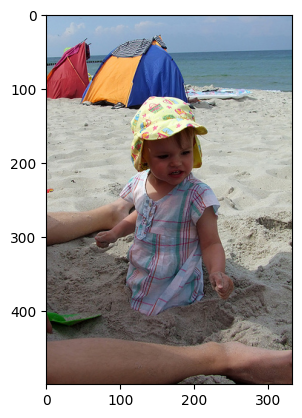

In [113]:
test_function("Three men on mountain bikes go over a sand hill .	",
              test_img_vector,
              test_img_directory,
              tokenizer,
              bert_model,
              prohib_words, 
              text_scaler, 
              img_scaler
             )

100%|██████████| 100/100 [00:00<00:00, 34094.49it/s]

Prediction score: 0.3104102611541748
File name: 3730011701_5352e02286.jpg
Query: The lady in the multi-colored shirt has a necklace on a white object in her hand .


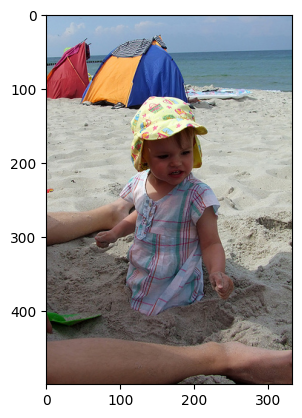

In [114]:
test_function("The lady in the multi-colored shirt has a necklace on a white object in her hand .",
              test_img_vector,
              test_img_directory,
              tokenizer,
              bert_model,
              prohib_words, 
              text_scaler, 
              img_scaler
             )

## Выводы

В рамках настоящего проекта была реализована демонстрационная модель по подбору изображений по запросу.

**Было выполнено:**

1. Загрузка библиотек.
2. Загрузка данных.
3. Определение функций.
4. Исследовательский анализ.
5. Векторизация изображений.
6. Векторизация текстов.
7. Объединение векторов.
8. Подготовка данных и обучение модели предсказания.
9. Тестирование модели.


В качестве модели предсказания релевантности использовалась полносвязная модель с двумя скрытыми слоями.

| Параметры модели   | Значение       |
|--------------------|----------------|
| n_hidden_neurons_1 | 512            |
| n_hidden_neurons_2 | 8             |
| dropout_rate_1     | 0.3            |
| dropout_rate_2     | 0.5            |
| weight_init        | xavier_normal_ |

Для векторизации изображений была выбрана модель **ResNet18**.

Для векторизации текста была выбрана модель: **all-MiniLM-L6-v2**.


В целом модель захватывает основые детали при подборе изображний, но релевантность довольно низкая.

На мой взгляд это связано с данным для обучения, где высокая доля запросов не соответствует изображению.

[Вернуться в начало тетрадки](#head)